# Task 2: Text Chunking, Embedding, and Vector Store Indexing


****

In [ ]:
!pip install langchain openai chromadb tiktoken pypdf sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.5/305.5 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 18.6 MB/s eta

In [ ]:
!pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from pathlib import Path
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
from langchain.docstore.document import Document
from langchain_community.embeddings import SentenceTransformerEmbeddings
import pickle
import uuid
from langchain_community.embeddings import SentenceTransformerEmbeddings # Import the correct class
from langchain.embeddings import HuggingFaceEmbeddings


## set up the path to save and load the data

In [ ]:

# Set up paths
#DATA_PATH = Path('data')
VECTOR_STORE_PATH = Path('vector_store')
#INPUT_FILE = DATA_PATH / 'filtered_complaints.csv'
VECTOR_STORE_FILE = VECTOR_STORE_PATH / 'faiss_index'

# Create vector store directory if it doesn't exist
VECTOR_STORE_PATH.mkdir(exist_ok=True)

# Load filtered dataset
#print("Loading filtered dataset...")
#df = pd.read_csv(INPUT_FILE)

## uploading of  files from prevous task

In [ ]:
# uploading of  files from prevous task
from google.colab import files
uploaded=files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving filtered2_data.csv to filtered2_data.csv
User uploaded file "filtered2_data.csv" with length 177655742 bytes


In [38]:
df=pd.read_csv('/content/filtered2_data.csv')
df.head(10)


,complaint_id,product,narrative,narrative_length,cleaned_narrative
0,14069121,Credit card,A XXXX XXXX card was opened under my name by a...,91,a card was opened under my name by a fraudster...
1,14047085,Credit card,"Dear CFPB, I have a secured credit card with c...",156,dear cfpb i have a secured credit card with ci...
2,14040217,Credit card,I have a Citi rewards cards. The credit balanc...,233,i have a citi rewards cards the credit balance...
3,13968411,Credit card,b'I am writing to dispute the following charge...,454,b i am writing to dispute the following charge...
4,13965746,Credit card,"Although the account had been deemed closed, I...",170,although the account had been deemed closed i ...
5,14025020,Credit card,I was trying to log into my account and it wou...,114,i was trying to log into my account and it wou...
6,13950990,Credit card,I received an email in XXXX from my XXXX XXXX ...,190,i received an email in from my saying that i w...
7,13938213,Credit card,"I filed a dispute with my bank, Truist, on my ...",520,i filed a dispute with my bank truist on my bu...
8,14001321,Credit card,"Ongoing payment situation with Best Buy, my pa...",18,ongoing payment situation with best buy my pay...
9,12629540,Credit card,I just had the worst experience ever with thei...,450,i just had the worst experience ever with thei...


## Narrative Length statistics

In [ ]:
# Check narrative lengths
df['narrative_length'] = df['cleaned_narrative'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
print("\nNarrative Length Statistics:")
print(df['narrative_length'].describe())


Narrative Length Statistics:
count    82164.000000
mean      1018.519132
std       1141.569812
min          0.000000
25%        318.000000
50%        710.000000
75%       1317.000000
max      30752.000000
Name: narrative_length, dtype: float64


**Initialize text splitter**

In [ ]:
# Initialize text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Reduced to handle shorter narratives
    chunk_overlap=50,
    length_function=len,
    separators=["\n\n", "\n", ".", " ", ""]
)

**Initialize embedding model**

In [ ]:
# Initialize embedding model
print("Loading embedding model...")

# Initialize SentenceTransformerEmbeddings with the model name
embedding_model = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

Loading embedding model...


/tmp/ipython-input-12-3594790335.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access p

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# **Chunking**
- preparing of document for chunking
- split narrative into Data
- Create Document objects with metadata

In [ ]:
# Prepare documents in batches
batch_size = 1000
documents = []
for start_idx in range(0, len(df), batch_size):
    batch_df = df.iloc[start_idx:start_idx + batch_size]
    for idx, row in batch_df.iterrows():
        try:
            complaint_id = str(row.get('Complaint ID', uuid.uuid4()))
            product = row['product']
            narrative = row['cleaned_narrative']
            if pd.isna(narrative) or not narrative.strip():
                print(f"Skipping empty narrative for Complaint ID {complaint_id}")
                continue
            chunks = text_splitter.split_text(narrative)
            for chunk_idx, chunk in enumerate(chunks):
                doc = Document(
                    page_content=chunk,
                    metadata={
                        'complaint_id': complaint_id,
                        'product': product,
                        'chunk_index': chunk_idx
                    }
                )
                documents.append(doc)
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
    print(f"Processed batch {start_idx // batch_size + 1}: {len(documents)} chunks so far")

In [ ]:
len(documents)

220221

## Desplaying of sample chunked documents

In [31]:
# to display chunked text
documents[:5]

[Document(metadata={'complaint_id': 'ad16a24c-a0c7-411e-b10e-4eab0e3b23b0', 'product': 'Credit card', 'chunk_index': 0}, page_content='a card was opened under my name by a fraudster i received a notice from that an account was just opened under my name i reached out to to state that this activity was unauthorized and not me confirmed this was fraudulent and immediately closed the card however they have failed to remove this from the three credit agencies and this fraud is now impacting my credit score based on a hard credit pull done by that was done by a fraudster'),
 Document(metadata={'complaint_id': 'dc38017d-4fe2-417b-ae24-0a632657665c', 'product': 'Credit card', 'chunk_index': 0}, page_content='dear cfpb i have a secured credit card with citibank which is changed to unsecured card and i have been calling n waitting for the check release the secured amount for rhat credit card they told me to wait then today they told me someone cashed my check but their system doesnt have info as

In [57]:
import pandas as pd

# Convert to DataFrame
DF = pd.DataFrame([{
    'text': doc.page_content,
    **doc.metadata  # expand metadata keys into columns
} for doc in documents])
DF.head()

,text,complaint_id,product,chunk_index
0,a card was opened under my name by a fraudster...,ad16a24c-a0c7-411e-b10e-4eab0e3b23b0,Credit card,0
1,dear cfpb i have a secured credit card with ci...,dc38017d-4fe2-417b-ae24-0a632657665c,Credit card,0
2,wait for some form that might be sent to me vi...,dc38017d-4fe2-417b-ae24-0a632657665c,Credit card,1
3,i have a citi rewards cards the credit balance...,8848aa7b-8700-4fc8-b475-7d75414f6cff,Credit card,0
4,citi abruptly slashes the balance of my card f...,8848aa7b-8700-4fc8-b475-7d75414f6cff,Credit card,1


from matplotlib import pyplot as plt
_df_7['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['chunk_index'].plot(kind='hist', bins=20, title='chunk_index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_9.groupby('text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_10.groupby('complaint_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='index', y='chunk_index', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['chunk_index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('text')):
  _plot_series(series, series_name, i)
  fig.legend(title='text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('chunk_index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['chunk_index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('complaint_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='complaint_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('chunk_index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('text')):
  _plot_series(series, series_name, i)
  fig.legend(title='text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('complaint_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='complaint_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_16['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['chunk_index'].plot(kind='line', figsize=(8, 4), title='chunk_index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['complaint_id'].value_counts()
    for x_label, grp in _df_18.groupby('text')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('text')
_ = plt.ylabel('complaint_id')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='index', y='text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['complaint_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='index', y='complaint_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='chunk_index', y='text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['complaint_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='chunk_index', y='complaint_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# Generate embeddings and create vector **store**

In [ ]:
!pip install langchain-huggingface

In [ ]:
# model loading
print("Loading embedding model...")
# Initialize SentenceTransformerEmbeddings with the model name
embedding_model = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

Loading embedding model...


/tmp/ipython-input-12-1013958982.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access p

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# **Generate embeddings and create vector store**

In [13]:


# Extract texts
texts = [doc.page_content for doc in documents]
metadatas = [doc.metadata for doc in documents]

# Embed in batches
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True)


Batches:   0%|          | 0/3441 [00:00<?, ?it/s]

## sample of Embedded vector

In [15]:
# displaying of some vector
for i in range(3):
    print(f"\n📄 Text {i+1}:")
    print(texts[i])
    print("\n🔢 Embedding (first 10 dimensions):")
    print(embeddings[i][:20])


📄 Text 1:
a card was opened under my name by a fraudster i received a notice from that an account was just opened under my name i reached out to to state that this activity was unauthorized and not me confirmed this was fraudulent and immediately closed the card however they have failed to remove this from the three credit agencies and this fraud is now impacting my credit score based on a hard credit pull done by that was done by a fraudster

🔢 Embedding (first 10 dimensions):
[-0.03698348  0.02451562 -0.07761158  0.01777066  0.00104701 -0.01522342
  0.06904987 -0.05504381  0.04396292 -0.07325038  0.0357715   0.00561181
  0.06101044 -0.03145946 -0.02316689 -0.0226655   0.02141607  0.08439337
  0.00162156  0.02999535]

📄 Text 2:
dear cfpb i have a secured credit card with citibank which is changed to unsecured card and i have been calling n waitting for the check release the secured amount for rhat credit card they told me to wait then today they told me someone cashed my check but th

In [20]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 21.5 MB/s eta 0:00:00


# saving as the vector and the Faiss_index

In [21]:

# Build (text, embedding) tuples
text_embedding_pairs = list(zip(texts, embeddings))

# Create FAISS vector store
vector_store = FAISS.from_embeddings(
    text_embedding_pairs,
    embedding=model,           # model here should implement an .embed_query() method (SentenceTransformer is okay)
    metadatas=metadatas
)


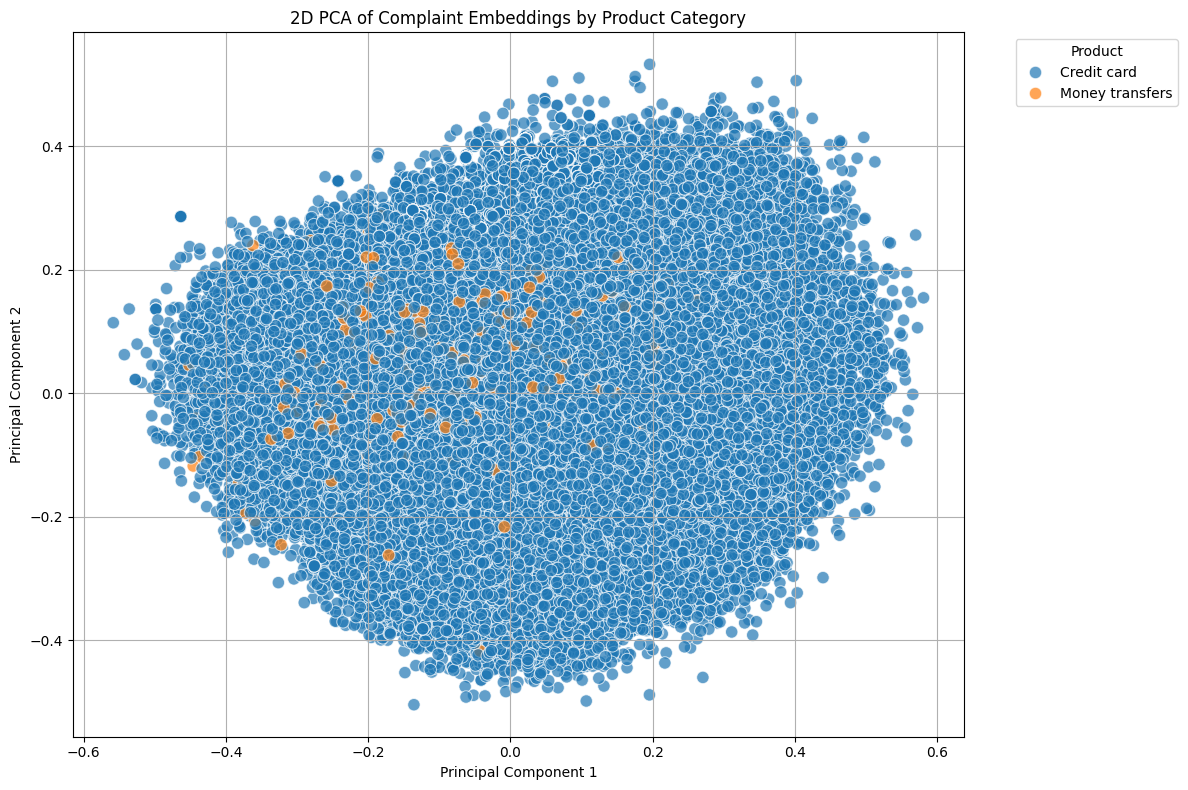

In [62]:
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)
DF['x'] = embeddings_2d[:, 0]
DF['y'] = embeddings_2d[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='x', y='y',
    hue='product',
    palette='tab10',
    data=DF,
    alpha=0.7,
    s=80
)

plt.title('2D PCA of Complaint Embeddings by Product Category')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Save vector store**

In [22]:
vector_store.save_local("faiss_store/")


In [23]:
# Set up paths
VECTOR_STORE_PATH = Path('vector_store')
VECTOR_STORE_FILE = VECTOR_STORE_PATH / 'faiss_index'
# Create vector store directory if it doesn't exist
VECTOR_STORE_PATH.mkdir(exist_ok=True)

print(f"Saving vector store to {VECTOR_STORE_FILE}...")
vector_store.save_local(VECTOR_STORE_FILE)

Saving vector store to vector_store/faiss_index...


In [24]:
# Save embedding model for future use (optional)
with open(VECTOR_STORE_PATH / 'embedding_model.pkl', 'wb') as f:
    pickle.dump(embedding_model, f)

print(f"Vector store created with {len(documents)} chunks.")

Vector store created with 220221 chunks.


In [26]:
import shutil

# Zip the entire folder
shutil.make_archive("vector_store", 'zip', "vector_store")

'/content/vector_store.zip'

In [29]:
# To save the vector from coolab to local machine
with open('vector_store.pkl', 'wb') as f:
    pickle.dump(vector_store, f)

print(f"Saving vector store to ...")

Saving vector store to ...


In [28]:
from google.colab import files

files.download('faiss_store.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>